# Getting the dataset
Firstly, we load the dataset from the individual files into a single Pandas DataFrame.
In the cell bellow, the entire process of getting the prompts, marks and essays is done.
Finally, we have 456 essays.

In [45]:
import pandas as pd
import glob
import re
import os 

prompts_paths = glob.glob(".\\prompts\\*\\*.txt")
essays_paths = glob.glob(".\\prompts\\*\\*\\*.txt")
marks_paths = glob.glob(".\\prompts\\*\\*\\*.csv")

df = pd.DataFrame(columns=['prompt', 'essay', 'mark1', 'mark2', 'mark3', 'mark4', 'mark5'])
for prompt_path in prompts_paths:
    prompt_number = re.search("(\d+)", prompt_path).group(0)
    with open(prompt_path, 'r') as f:
        prompt = f.read()
        find1 = re.findall("(.*?)Como enviar sua redação", prompt)
        find2 = re.findall("(.*?)ObservaçõesSeu", prompt)
        if find1:
            prompt = find1[0]
        if find2:
            prompt = find2[0]
    essays = []
    marks = pd.DataFrame({0: [], 1:[], 2:[], 3:[], 4:[]})
    for essay_path in essays_paths:
        #Get essays for this prompt, and the original one
        if "prompt"+str(prompt_number)+"\\" in essay_path and "original" in essay_path:
            with open(essay_path, "r", encoding='utf-8') as original:
                essay = original.read()
                essays.append(essay)
            mark_path = essay_path.replace("_original.txt", "_mark.csv")
            mark = pd.read_csv(mark_path).transpose().drop(axis=0, index="Topics").drop(columns=[5])
            marks = pd.concat([marks, mark], ignore_index=True)
    prompts = [prompt] * len(essays)
    sub_df = pd.DataFrame({'prompt': prompts, 'essay': essays, 'mark1': marks[0], 
                           'mark2':marks[1], 'mark3':marks[2], 
                           'mark4':marks[3], 'mark5':marks[4]})
    df = pd.concat([df, sub_df], ignore_index=True)
len(df)

456

The cell bellow creates a prompt_index, which makes easier to manipulate the data. It also sums all the 5 marks into an overall score.

In [46]:
# Reduce the size of the prompt
df['prompt_index'] = pd.factorize(df['prompt'])[0]

# Get the total score
df['total'] = df['mark1'] + df['mark2'] + df['mark3'] + df['mark4'] + df['mark5']
df.head()

,prompt,essay,mark1,mark2,mark3,mark4,mark5,total
0,O número de pessoas desempregadas no mundo dev...,Qualificações para o mercado de trabalho\n\nAn...,80,120,120,80,80,480
1,O número de pessoas desempregadas no mundo dev...,Futuro da crise do desemprego\n\nA Qualificaçã...,80,80,80,80,80,400
2,O número de pessoas desempregadas no mundo dev...,O progresso da tecnologia\n\nNo decorrer dos s...,160,160,160,160,120,760
3,O número de pessoas desempregadas no mundo dev...,O advento tecnológico \n\nAs constantes mudanç...,160,120,120,120,120,640
4,O número de pessoas desempregadas no mundo dev...,"Transformações laborais\n\nA noção de emprego,...",120,120,120,120,120,600


This cell prints a pairplot of the 23 prompts and its 5 marks + total score.

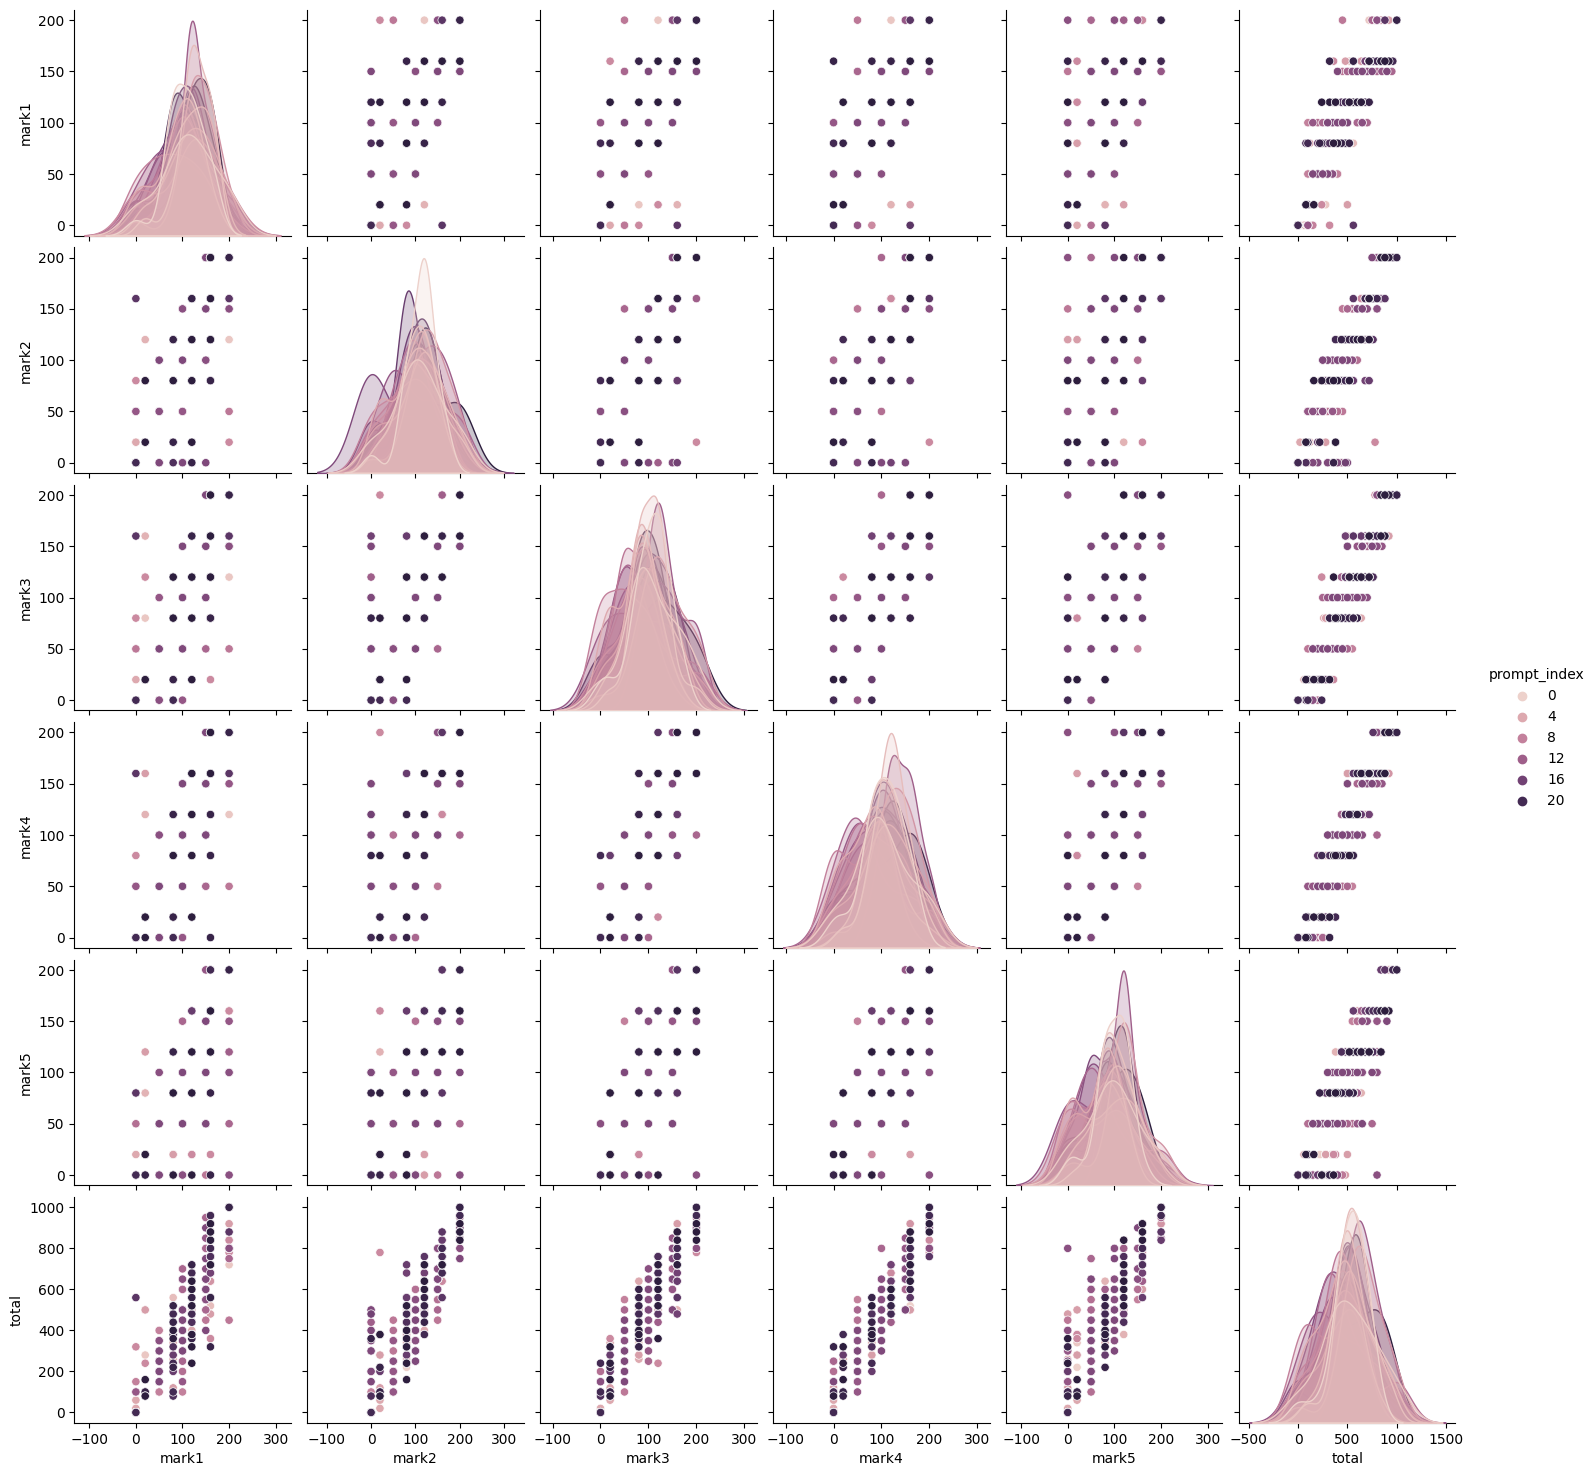

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.pairplot(df, hue='prompt_index')

The cell bellow converts the marks and total to integers, because they were objects. It also performs a summary of the scores.

In [49]:
df['mark1'] = df['mark1'].astype(int)
df['mark2'] = df['mark2'].astype(int)
df['mark3'] = df['mark3'].astype(int)
df['mark4'] = df['mark4'].astype(int)
df['mark5'] = df['mark5'].astype(int)
df['total'] = df['total'].astype(int)
df[['mark1','mark2','mark3','mark4','mark5','total']].describe()

,mark1,mark2,mark3,mark4,mark5,total
count,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000
mean,107.478070,102.083333,95.307018,99.671053,88.201754,492.741228
std,51.252441,54.874899,52.955653,55.842216,53.356060,244.227751
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,80.000000,80.000000,50.000000,80.000000,50.000000,357.500000
50%,120.000000,100.000000,100.000000,100.000000,80.000000,500.000000
75%,150.000000,127.500000,120.000000,150.000000,120.000000,640.000000
max,200.000000,200.000000,200.000000,200.000000,200.000000,1000.000000


# Visualizing the dataset
The cell bellow shows an histogram containing the number of essays (Count) with a certain overall score (total). It encompasses all essays from all prompts.

As we can see, it follows a normal distribution.

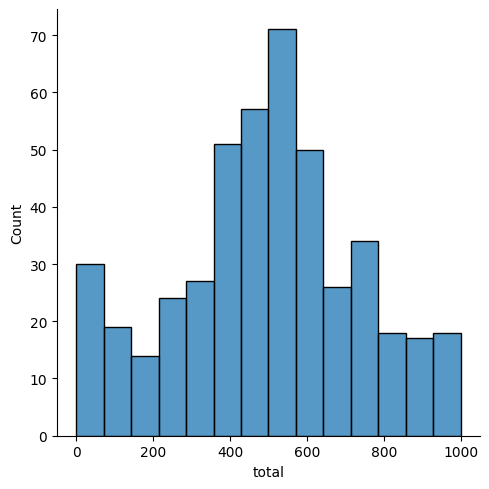

In [50]:
sns.displot(df, x="total")

The cell bellow contains the separate histograms for the 23 prompts. The majority of them seems to follow a normal distribution, even though there are a small number of essays to affirm so. 

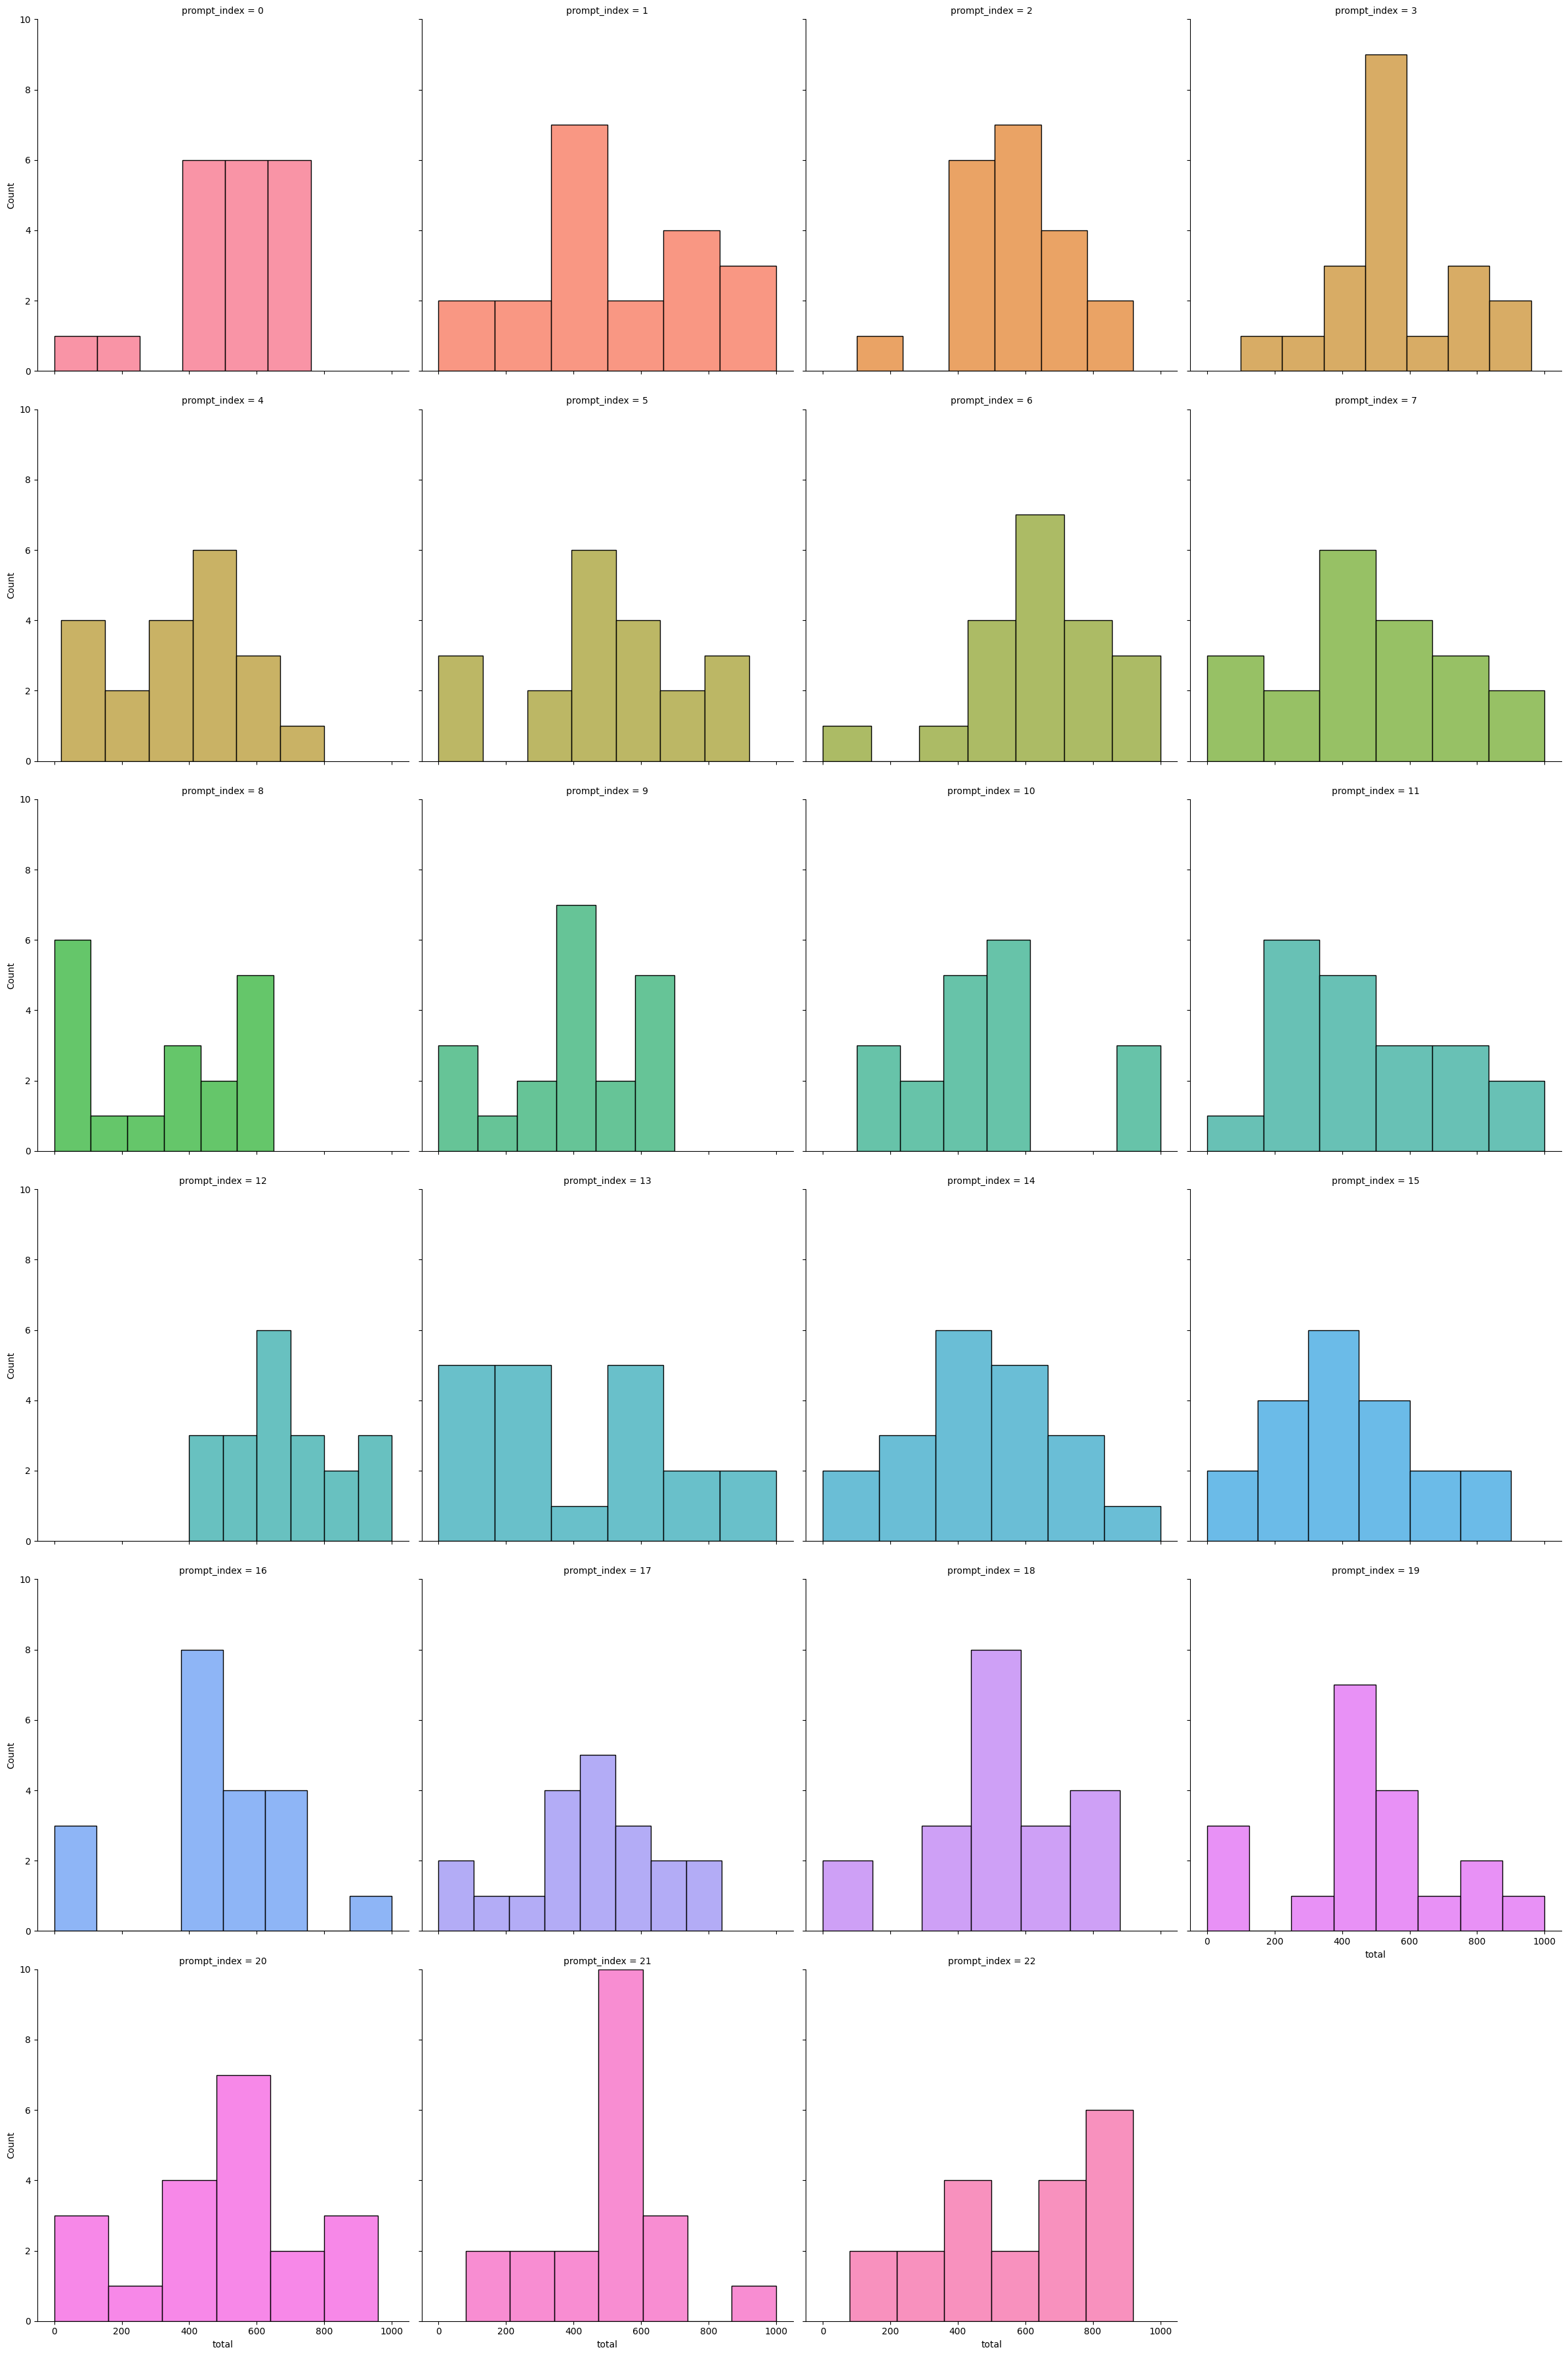

In [70]:
g = sns.FacetGrid(df, col="prompt_index", hue="prompt_index", col_wrap=4, height=6, ylim=(0, 10))
g.map(sns.histplot,'total')

The function bellow converts the text into a list of tokens (words). This cell also creates two new columns in the dataset:
a column containing the tokenized list and one containing the number of tokens in the text.

In [61]:
def tokenizer(text):
    tokenized = re.sub(r'[^\w\s]', '', text).split()
    return tokenized

df['tokenized'] = df['essay'].apply(tokenizer)
df['n_tokens'] = df['tokenized'].str.len()
df.head()

In this cell we verify the distribution of tokens across all essays, of all prompts. Once again, we have a normal distribution.

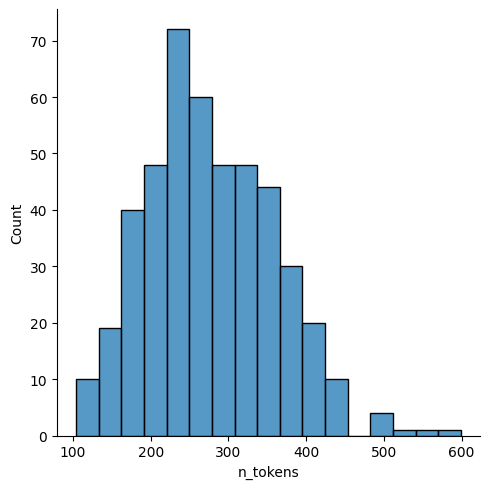

In [63]:
sns.displot(df, x="n_tokens")

This cell recreates the histogram plot for all of the 23 prompts.

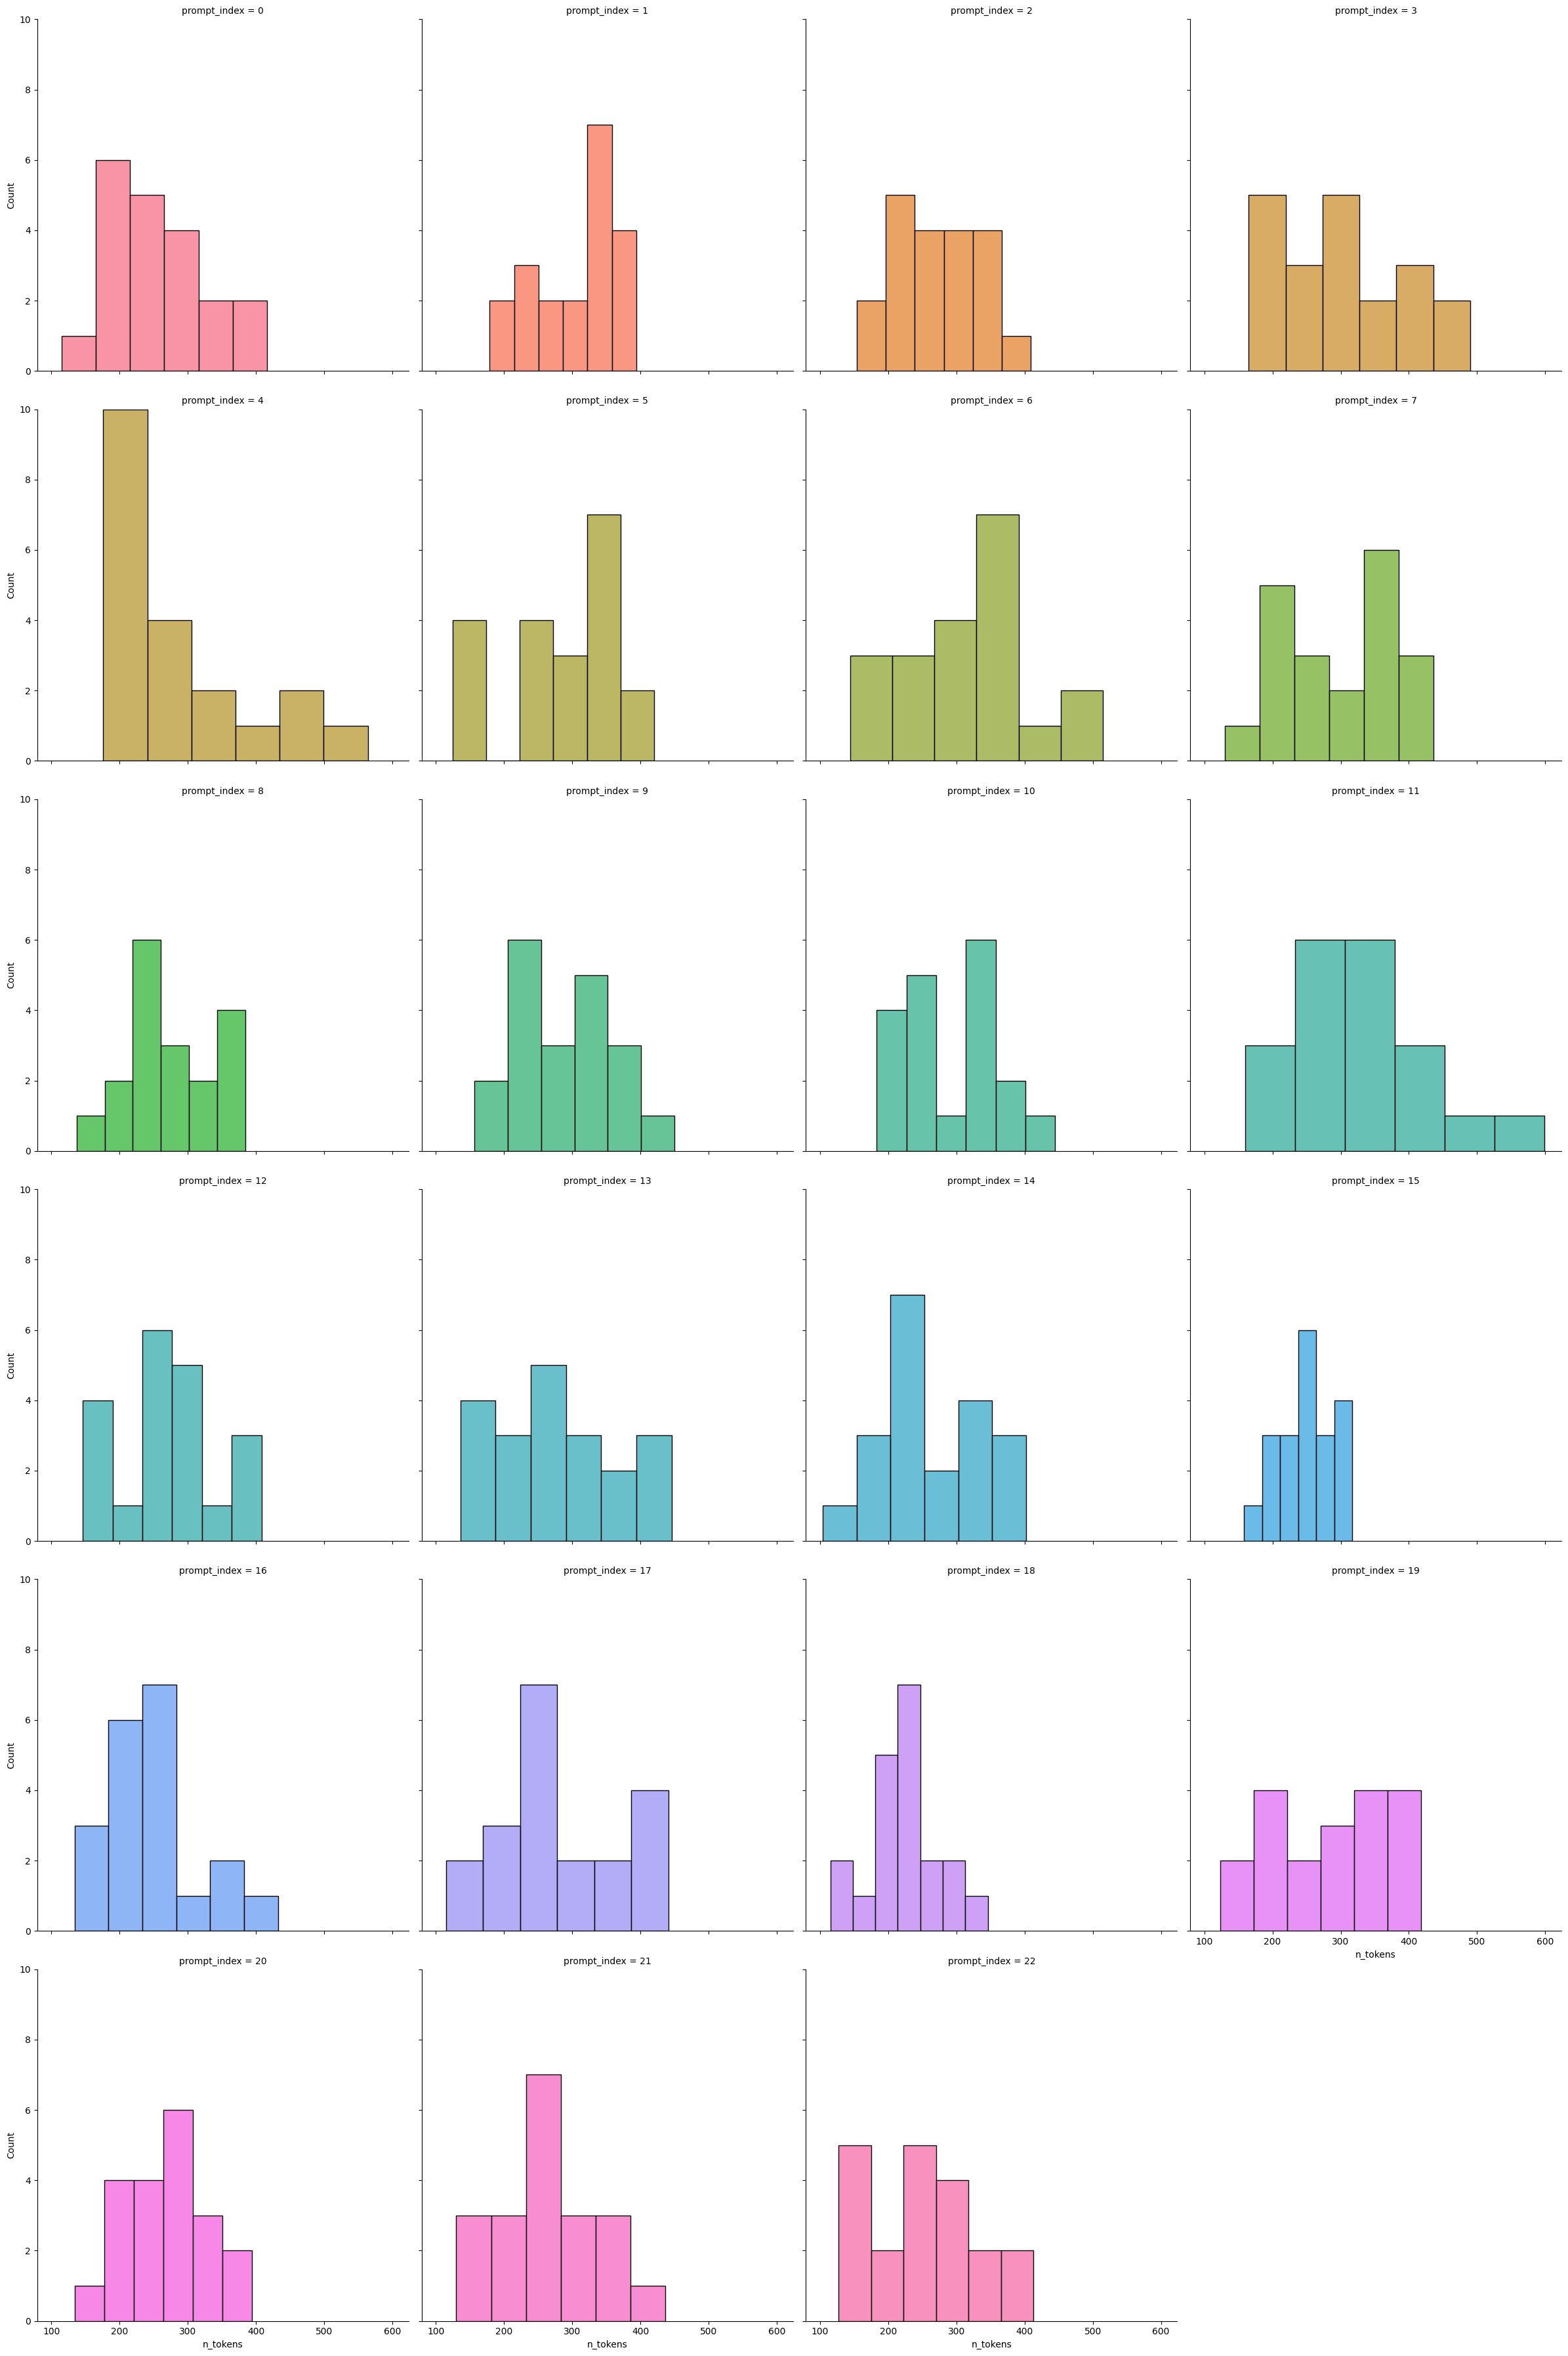

In [69]:
g = sns.FacetGrid(df, col="prompt_index", hue='prompt_index', col_wrap=4, height=6, ylim=(0, 10))
g.map(sns.histplot,'n_tokens')

In the cell bellow, we can verify that lower scores tend to be associeated with lower word count. However, it is not a direct correlation, since the highest scoring essays have around 300-400 words, while the maximum number of words is around 600.

<Axes: xlabel='n_tokens', ylabel='total'>

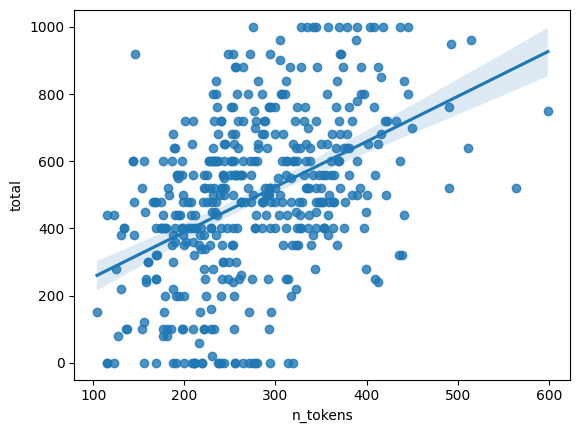

In [73]:
sns.regplot(x=df['n_tokens'], y=df['total'])